## SIR-X model


The SIR-X model http://rocs.hu-berlin.de/corona/docs/forecast/results_by_country/ is a simple but seems to be accurate model.

The population is described by **S** (fraction of people suspectible to the infection), **I** (fraction of people infected and spreading the infection), (**R** which is neither suspectible nor infected), and **X** (the number of "quarantineed" people). 

$X$ is roughly the number of cases reported by each country. 

The equations describing the evolution of $S$, $I$, $R$ and $X$ are self-explanatory:

$$\frac{dS}{dt} = -\alpha S I - k_0 S,  \quad \frac{dI}{dt} = \alpha S I - \beta I - k_0 I - k I, 
\quad \frac{dX}{dt} = - (k_0 + k) I, \quad \frac{dR}{dt} = k_0 S + \beta I.$$

The first equation controls the spread of the infection (the growth is proportional to the probability of meeting of $S$ and $I$), 
the constant $\beta$ controls the recovery / death process (and is roughly $\beta \approx \frac{1}{T}$, where $T$ is the characteristic time of the decease). 

The parameters $k_0$ and $k$ represent the measures taken: $k_0$ corresponds to social distancing / contract tracing, whereas $k$ controls the quarantine process for symptomatic individuals

To fit the model, one has to find the parameters of it $\alpha, \beta, k_0, k$ and the initial number of infected individuals $I_0$ such that the $X(t)$ approximates the observed cases $C(t)$. The true number of potentially infected people $I(t)$ can be much larger. 

Several optimization techniques can be used. We tried gradient-free optimization package **nevergrad**, however, 
right now we are doing the Bayesian optimization in order to give not only the values of parameters, but also the risk values. 


The data collection below is taken form a nice [Google Colab notebook](https://colab.research.google.com/drive/15R6bXKW--TSMXClMfHql8zU0ePOLEoa3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
#import pymc as pm
from scipy.integrate import odeint

%matplotlib inline

In [2]:
online = True

if online:
    COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
else:
    COVID_CONFIRMED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    


covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)
covid_deaths = pd.read_csv(COVID_DEATHS_URL)
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_confirmed.rename(columns={'Province/State':'State'}, inplace=True)
covid_deaths.rename(columns={'Province/State':'State'}, inplace=True)
covid_recovered.rename(columns={'Province/State':'State'}, inplace=True)


covid_confirmed.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,40,74,84,94,110,110,120,170,174,237
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,104,123,146,174,186,197,212,223,243,259
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,230,264,302,367,409,454,511,584,716,847
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,133,164,188,224,267,308,334,370,376,390
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,3,3,4,4,5,7,7,7,8


In [3]:
Country = 'Russia'
population = {"Russia" : 146745098, "Italy" : 60317000, "China" : 1404328000}

data_Russia_confirmed = covid_confirmed[covid_confirmed.Country == Country].values[0, 4:].astype(int)

data = np.empty((3, data_Russia_confirmed.shape[0]), dtype=np.int64)
data[0] = data_Russia_confirmed

data[1] = covid_deaths   [covid_deaths.Country    == Country].values[0, 4:].astype(int)
data[2] = covid_recovered[covid_recovered.Country == Country].values[0, 4:].astype(int)

data_normed = data.astype(np.float64) / population[Country]
data_normed_only_conf = data_normed[0] - data_normed[1] - data_normed[2]

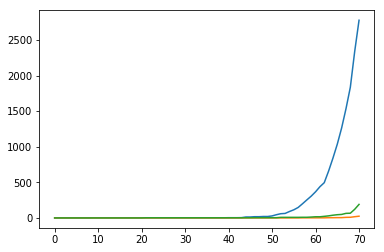

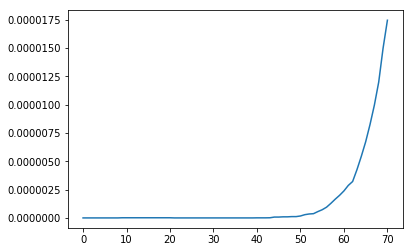

In [4]:
plt.plot(data.T);
plt.figure()
plt.plot(data_normed_only_conf);

In [5]:
@jit
def base_seir_model(init_vals, dt, N, params):
    res = np.empty((N, 4), dtype=np.float64)
    S = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    #print(I)
    return res


def seir_rhs(y, t, alpha, beta, gamma):
    S, E, I, R = y
    return [-beta*S*I, beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]

def base_seir_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(seir_rhs, init_vals, t, args=params)
    #return sol[::int(1/dt)]
    return sol

@jit
def sirx_rhs(x, t, alpha, beta, k0, k):
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = (alpha*S - beta - (k0 + k))*I
    dxdt = (k0 + k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])


def base_sirx_model_rhs(x, params):
    alpha, beta, k0, k = params
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = alpha*S*I - beta*I - k0*I - k*I
    dxdt = (k0+k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])

#@jit
def base_sirx_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(sirx_rhs, init_vals, t, args=params)
    #sol[np.isnan(sol)] = 1e20
    #sol[np.isinf(sol)] = 1e20
    return sol



# SIR Model (not working)
@jit
def base_sirf_model(init_vals, dt, N, params):
    res = np.empty((N, 3), dtype=np.float64)
    y = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    return res


In [7]:
#vals = []

data1 = data[0]
data1 = data1[data1>=3]
data1 = data1/population[Country]
#plt.plot(data1)

#true_cases = data_normed_only_conf[-20:]
#true_cases = data_normed_only_conf[data[0] >= 3]
#true_cases = data_normed[0][data[0] >= 3]
true_cases = data1


def obs(alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, cf = 1, N = len(true_cases), type_ret=2):
        # N is number of points (days)
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf
        res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[type_ret][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
    

def loss_fn(alpha, beta, k0, k, I0):
#def loss_fn(x):
#    alpha, beta, k0, k, I0 = x
    loss_val = np.linalg.norm( obs(alpha, beta, k0, k, I0) - true_cases )
#    if np.isnan(loss_val) or np.isinf(loss_val):
#        loss_val = 1e100
    return loss_val

_ = """
num_days = len(true_cases)-1
times = np.linspace(0, num_days, num_days+1)

def compute_fit(alpha, beta, k0, k, I0):
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    predicted_cases = sol[:, 2]
    return np.linalg.norm(true_cases-predicted_cases)


def predict(alpha, beta, I0, k0, k, num_days):
    times = np.linspace(0, num_days, num_days+1)
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    return sol

"""

In [8]:
import nevergrad as ng

In [9]:
def optimize():
    beta0 = 0.38 #d^{-1}
    R0 = 3.07
    alpha0 = R0*beta0
    #k0_0 = 1e-1
    #k_0 = 0.0

    alpha = ng.p.Scalar()
    alpha.value = alpha0
    alpha.value = 0.8921533322357904
    beta = ng.p.Scalar()
    beta.value = beta0
    beta.value = 0.6006857701497142
    I0 = ng.p.Scalar()
    I0.value = 1e-8
    I0.value = 2.0638693642381589e-07
    k0 = ng.p.Scalar()
    k = ng.p.Scalar()
    alpha.set_bounds(0.0, 10.0)
    beta.set_bounds(5e-2, 2.0)
    I0.set_bounds(0.0, 1e-4)
    k0.value = 1e-5
    k.value = 1e-5
    k0.value = 0.003774752347706235
    k.value = 0.018991858675810148
    #k0.set_bounds(0, 5e-2)
    #k.set_bounds(0, 5e-2)
    k0.set_bounds(0, 0.1)
    k.set_bounds(0, 0.1)

    instru = ng.p.Instrumentation(alpha, beta, k0, k, I0)
    optimizer = ng.optimizers.CMA(parametrization=instru, budget=20000, num_workers=6) # num_workers don't work :(
    #optimizer = ng.optimizers.CMA(parametrization=instru, budget=500000)

    recommendation = optimizer.minimize(loss_fn)
    #recommendation = optimizer.minimize(compute_fit)
    return recommendation

max_err = 1e100
for _ in range(30):
    print('.')
    recommendation = optimize()
    err = loss_fn(*recommendation.value[0])
    if err < max_err:
        max_err = err
        vals = recommendation.value[0]
        
max_err, vals
    

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Thu Apr  2 19:51:17 2020)


/Users/ivanoseledets/miniconda3/envs/pytorch/lib/python3.6/site-packages/nevergrad/parametrization/data.py:234: UserWarning: Bounds are 1.95 sigma away from each other at the closest, you should aim for at least 3 for better quality.
  warnings.warn(f"Bounds are {min_dist} sigma away from each other at the closest, "
/Users/ivanoseledets/miniconda3/envs/pytorch/lib/python3.6/site-packages/nevergrad/parametrization/data.py:234: UserWarning: Bounds are 0.0001 sigma away from each other at the closest, you should aim for at least 3 for better quality.
  warnings.warn(f"Bounds are {min_dist} sigma away from each other at the closest, "
/Users/ivanoseledets/miniconda3/envs/pytorch/lib/python3.6/site-packages/nevergrad/parametrization/data.py:234: UserWarning: Bounds are 0.1 sigma away from each other at the closest, you should aim for at least 3 for better quality.
  warnings.warn(f"Bounds are {min_dist} sigma away from each other at the closest, "
/Users/ivanoseledets/miniconda3/envs/pytor

KeyboardInterrupt: 

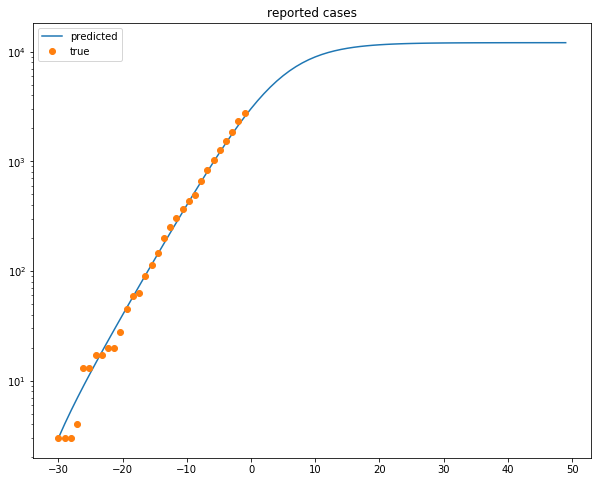

In [11]:
num_days = 80
time_scale = np.linspace(-len(true_cases)+1, num_days - len(true_cases), num_days)
time_scale_true = np.linspace(-len(true_cases)+1 , -1, len(true_cases))
plt.figure(figsize=(10, 8))
vals = (1.2173437044675621,
  0.9855553151918058,
  0.0,
  0.00022902367817583327,
  2.7873569184833206e-05)
alpha_g, beta_g, k0_g, k_g, I0_g = vals
plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=num_days, cf=1), "-", label="predicted");
plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
plt.legend();
plt.title('reported cases');
plt.yscale('log')

In [16]:
population[Country]*true_cases

array([   3.,    3.,    3.,    4.,   13.,   13.,   17.,   17.,   20.,
         20.,   28.,   45.,   59.,   63.,   90.,  114.,  147.,  199.,
        253.,  306.,  367.,  438.,  495.,  658.,  840., 1036., 1264.,
       1534., 1836., 2337., 2777.])

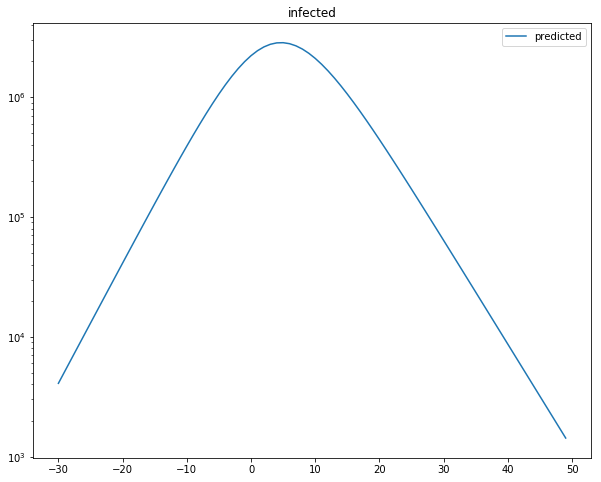

In [12]:
plt.figure(figsize=(10, 8))
vals = (1.2173437044675621,
  0.9855553151918058,
  0.0,
  0.00022902367817583327,
  2.7873569184833206e-05)
alpha_g, beta_g, k0_g, k_g, I0_g = vals
plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=80, type_ret=1), "-", label="predicted");
plt.legend();
plt.title('infected');
plt.yscale('log');

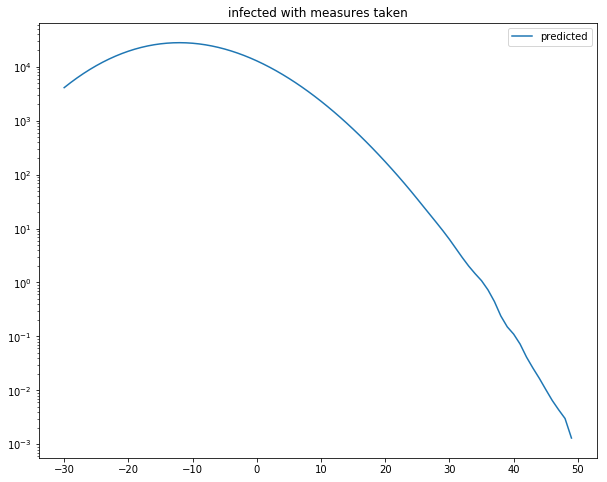

In [14]:
plt.figure(figsize=(10, 8))

vals = (1.2173437044675621,
  0.9855553151918058,
  1e-3,
  0.00022902367817583327,
  2.7873569184833206e-05)
alpha_g, beta_g, k0_g, k_g, I0_g = vals

plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g+1e-2, k_g, I0_g, N=80, type_ret=1), "-", label="predicted");
plt.legend();
plt.title('infected with measures taken');
plt.yscale('log');

In [15]:
recommendation.value[0]

NameError: name 'recommendation' is not defined

In [67]:
good_vals_1 = (0.8921533322357904,
 0.6006857701497142,
 0.003774752347706235,
 0.018991858675810148,
 2.0638693642381589e-07)

good_vals_2 = (1.4620735715158846,
 1.1550524698389562,
 0.00012016896136317736,
 0.09431369871672939,
 8.85266762057214e-08)


In [ ]:
(0.7028386750218786, 0.5248873953209352, 0.0026616813473804538, 0.0, 1e-05)

In [69]:
loss_fn(*good_vals_1), loss_fn(*recommendation.value[0])

(2.938729818873531e-06, 5.876705339440785e-07)

In [62]:
print(sorted(ng.optimizers.registry.keys()))

['ASCMA2PDEthird', 'ASCMADEQRthird', 'ASCMADEthird', 'AlmostRotationInvariantDE', 'BO', 'CM', 'CMA', 'CMandAS', 'CMandAS2', 'CMandAS3', 'CauchyLHSSearch', 'CauchyOnePlusOne', 'CauchyScrHammersleySearch', 'Cobyla', 'DE', 'DiagonalCMA', 'DiscreteOnePlusOne', 'DoubleFastGADiscreteOnePlusOne', 'EDA', 'ES', 'FCMA', 'HaltonSearch', 'HaltonSearchPlusMiddlePoint', 'HammersleySearch', 'HammersleySearchPlusMiddlePoint', 'LHSSearch', 'LargeHaltonSearch', 'LhsDE', 'MEDA', 'MPCEDA', 'MetaRecentering', 'MixES', 'MultiCMA', 'MultiScaleCMA', 'MutDE', 'NGO', 'NaiveIsoEMNA', 'NaiveTBPSA', 'NelderMead', 'NoisyBandit', 'NoisyDE', 'NoisyDiscreteOnePlusOne', 'NoisyOnePlusOne', 'ORandomSearch', 'OScrHammersleySearch', 'OnePlusOne', 'OptimisticDiscreteOnePlusOne', 'OptimisticNoisyOnePlusOne', 'PBIL', 'PCEDA', 'PSO', 'ParaPortfolio', 'Portfolio', 'Powell', 'QORandomSearch', 'QOScrHammersleySearch', 'QrDE', 'RCobyla', 'RPowell', 'RSQP', 'RandomSearch', 'RandomSearchPlusMiddlePoint', 'RealSpacePSO', 'RecES', 'Re

In [138]:
cf = 4
N = 9
dt = 1.0/cf
num = (N-1)*cf
t_max = (num)*dt
t = np.linspace(0, t_max, num+1)
t

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25,
       4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ])

In [139]:
t[::cf]

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])